In [1]:
!pip install tqdm
!apt-get install unrar -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
!unrar x UTKFace.rar

Streaming output truncated to the last 5000 lines.
Extracting  UTKFace/53_0_1_20170116192938845.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_1_20170117181950281.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_1_20170120222553113.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_1_20170120222956787.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_1_20170120223004304.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170104210010763.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170112215433623.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170112221930338.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170116192925824.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20170116192934154.jpg.chip.jpg                 77%  OK 
Extracting  UTKFace/53_0_2_20

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import csv
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers,models,Sequential
from tensorflow.keras.models import load_model
import gc

In [4]:
gc.collect()

0

In [5]:
image_folder = "UTKFace"

In [6]:
csv_file = "face_labels.csv"

In [7]:
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'age', 'gender'])

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            try:
                age, gender, *_ = filename.split("_")
                writer.writerow([filename, age, gender])
            except ValueError:
                print("Skipping file with unexpected format:", filename)

print(f"CSV file created: {csv_file}")

CSV file created: face_labels.csv


In [8]:
df=pd.read_csv('face_labels.csv')
df.sample(5)

,image_name,age,gender
20201,36_0_0_20170117135442285.jpg.chip.jpg,36,0
11047,24_1_4_20170103230137338.jpg.chip.jpg,24,1
22632,88_0_0_20170120230341067.jpg.chip.jpg,88,0
21222,28_0_0_20170113132654464.jpg.chip.jpg,28,0
6707,1_0_3_20161219225952240.jpg.chip.jpg,1,0


(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

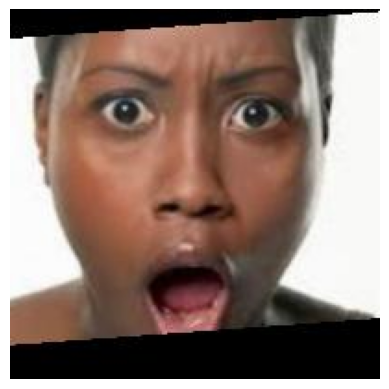

In [9]:
image_path = os.path.join(image_folder, df.image_name[1000])
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')

In [10]:
df.shape

(23708, 3)

In [11]:
img = cv2.imread(os.path.join(image_folder, df.image_name[1000]))
print("Shape:", img.shape)

Shape: (200, 200, 3)


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  8,  10,  10],
        [  0,   0,   0],
        [  5,   7,   7]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [ 14,  16,  16],
        [244, 246, 246]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [253, 255, 255],
        [243, 245, 245],
        [238, 240, 240]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
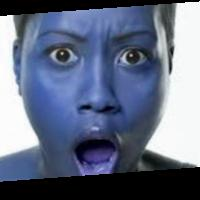

In [12]:
img

In [13]:
def reshape_img(image_folder,image_name):
    img = cv2.imread(os.path.join(image_folder,image_name))
    img_resized = cv2.resize(img, (200,200))
    return img_resized/255

In [14]:
X=df.drop(['age'],axis='columns')
Y=df.age

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1)

In [16]:
X_gen_det=X_train.drop(['gender'],axis='columns')
X_gen_det.head()

,image_name
15723,14_1_0_20170109204135732.jpg.chip.jpg
23690,31_0_1_20170117181933252.jpg.chip.jpg
18078,36_1_4_20170117180642329.jpg.chip.jpg
2547,30_1_4_20170117194826836.jpg.chip.jpg
7833,35_0_0_20170104201328371.jpg.chip.jpg


In [17]:
Y_gen_det=X_train.gender
Y_gen_det.head()

,gender
15723,1
23690,0
18078,1
2547,1
7833,0


In [18]:
X_gen_det.image_name.shape

(21337,)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=3, verbose=1)
]

In [20]:
def compute(cnn_gender, X_gen_det_img, Y_gen_det_batch):
    cnn_gender.fit(np.array(X_gen_det_img), np.array(Y_gen_det_batch), epochs=10, batch_size=8)
    return cnn_gender

In [21]:
img_height=img_width=200
data_aug = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [22]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

if os.path.exists("gender_model.keras"):
    model = load_model("gender_model.keras")
    print("Loaded saved model.")
else:
    cnn_gender=Sequential([
      data_aug,
      #cnn
      layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(200,200,3)),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      #dense
      layers.Flatten(),
      layers.Dense(256,activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128,activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(64,activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1,activation='sigmoid')
    ])
    cnn_gender.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
def preprocess(X_gen_det,image_folder,x,y):
    X_gen_det_img=[]
    for image_name in tqdm(X_gen_det.image_name[x:y], desc="Processing images"):
        try:
            img = reshape_img(image_folder, image_name)
            X_gen_det_img.append(img)
        except Exception as e:
            print(f"Skipping {image_name}: {e}")
    return X_gen_det_img

In [24]:
def np_conversion(cnn_gender, X_gen_det_img, Y_gen_det_batch):
    X_gen_det_img = np.array(X_gen_det_img)
    Y_gen_det_batch = np.array(Y_gen_det_batch)
    cnn_gender = compute(cnn_gender, X_gen_det_img, Y_gen_det_batch)
    return cnn_gender

In [25]:
done = 0
while done < X_gen_det.image_name.shape[0]:
    end = min(done + 2000, X_gen_det.image_name.shape[0])
    X_gen_det_img = preprocess(X_gen_det, image_folder, done, end)
    cnn_gender = np_conversion(cnn_gender, X_gen_det_img, Y_gen_det[done:end])
    cnn_gender.save("gender_model.keras")
    print(f"Saved model after batch {done}-{end}")
    done = end
    # Clean up RAM (without clearing model session)
    del X_gen_det_img
    gc.collect()


Processing images: 100%|██████████| 2000/2000 [00:01<00:00, 1166.71it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5195 - loss: 0.6955
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6532 - loss: 0.6342
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6858 - loss: 0.6144
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7236 - loss: 0.5618
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7410 - loss: 0.5527
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7679 - loss: 0.4836
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7848 - loss: 0.4783
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8005 - loss: 0.4522
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8015 - loss: 0.4449
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7924 - loss: 0.4602
Saved model after batch 0-2000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2465.71it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7520 - loss: 0.4912
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7958 - loss: 0.4510
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7977 - loss: 0.4300
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8077 - loss: 0.4122
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8227 - loss: 0.3960
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8342 - loss: 0.3919
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8373 - loss: 0.3636
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8269 - loss: 0.3690
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8339 - loss: 0.3674
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8348 - loss: 0.3630
Saved model after batch 2000-4000


Processing images: 100%|██████████| 2000/2000 [00:01<00:00, 1842.88it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8204 - loss: 0.4354
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8143 - loss: 0.3951
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8499 - loss: 0.3566
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8395 - loss: 0.3604
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8366 - loss: 0.3591
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8446 - loss: 0.3470
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8561 - loss: 0.3296
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8620 - loss: 0.3227
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8577 - loss: 0.3309
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8526 - loss: 0.3382
Saved model after batch 4000-6000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2409.00it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8608 - loss: 0.3655
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8554 - loss: 0.3216
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8613 - loss: 0.3061
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8718 - loss: 0.3074
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8741 - loss: 0.2847
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8750 - loss: 0.2781
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8822 - loss: 0.2831
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8827 - loss: 0.2691
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8818 - loss: 0.2800
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8799 - loss: 0.2675
Saved model after batch 6000-8000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2398.48it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8463 - loss: 0.3087
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8608 - loss: 0.3199
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8826 - loss: 0.2624
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8807 - loss: 0.2868
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8838 - loss: 0.2813
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8888 - loss: 0.2750
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8904 - loss: 0.2552
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8905 - loss: 0.2650
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8892 - loss: 0.2584
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8974 - loss: 0.2435
Saved model after batch 8000-10000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2477.66it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8818 - loss: 0.2920
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8717 - loss: 0.3103
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8803 - loss: 0.2886
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9029 - loss: 0.2549
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8677 - loss: 0.3103
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8891 - loss: 0.2694
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8946 - loss: 0.2466
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9024 - loss: 0.2418
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8940 - loss: 0.2402
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8957 - loss: 0.2532
Saved model after batch 10000-12000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2360.16it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8580 - loss: 0.3086
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8918 - loss: 0.2651
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8898 - loss: 0.2599
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8882 - loss: 0.2575
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8799 - loss: 0.2638
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8878 - loss: 0.2469
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8980 - loss: 0.2192
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8838 - loss: 0.2465
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9010 - loss: 0.2336
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9013 - loss: 0.2318
Saved model after batch 12000-14000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2429.91it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8702 - loss: 0.3028
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8784 - loss: 0.2822
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8859 - loss: 0.2741
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8989 - loss: 0.2335
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8951 - loss: 0.2484
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8928 - loss: 0.2501
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8949 - loss: 0.2316
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9050 - loss: 0.2348
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9121 - loss: 0.2121
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9017 - loss: 0.2181
Saved model after batch 14000-16000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2485.03it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8799 - loss: 0.2741
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8928 - loss: 0.2578
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8876 - loss: 0.2621
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8991 - loss: 0.2401
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9028 - loss: 0.2362
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9010 - loss: 0.2250
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9070 - loss: 0.2155
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8982 - loss: 0.2223
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9215 - loss: 0.1931
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9087 - loss: 0.2158
Saved model after batch 16000-18000


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2477.77it/s]


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8730 - loss: 0.2997
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8832 - loss: 0.2801
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8876 - loss: 0.2530
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9053 - loss: 0.2281
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9033 - loss: 0.2205
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9055 - loss: 0.2196
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9263 - loss: 0.1849
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8974 - loss: 0.2408
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9072 - loss: 0.2305
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9265 - loss: 0.1906
Saved model after batch 18000-20000


Processing images: 100%|██████████| 1337/1337 [00:00<00:00, 2435.65it/s]


Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8916 - loss: 0.2666
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8963 - loss: 0.2454
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8948 - loss: 0.2358
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9185 - loss: 0.2077
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9065 - loss: 0.2337
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9005 - loss: 0.2358
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9138 - loss: 0.1913
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9244 - loss: 0.1957
Epoch 9/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9134 - loss: 0.2066
Epoch 10/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9245 - loss: 0.1820
Saved model after batch 20000-21337


In [26]:
X_test_gen_det=X_test.drop(['gender'],axis='columns')
X_test_gen_det.head()

,image_name
8839,24_1_4_20170116220449622.jpg.chip.jpg
14463,55_0_3_20170119181109749.jpg.chip.jpg
5598,62_1_0_20170104183415429.jpg.chip.jpg
4750,48_1_1_20170109220559770.jpg.chip.jpg
9446,2_1_2_20161219140840080.jpg.chip.jpg


In [27]:
Y_test_gen_det=X_test.gender
Y_test_gen_det.head()

,gender
8839,1
14463,0
5598,1
4750,1
9446,1


In [28]:
cnn_gender = load_model("gender_model.keras")
print("Model loaded.")

Model loaded.


In [29]:
def predict_batch(X_test_gen_det, image_folder, x, y):
    X_test_img = []
    batch_filenames = []
    for image_name in tqdm(X_test_gen_det.image_name[x:y], desc="Processing images"):
        try:
            img = reshape_img(image_folder, image_name)
            X_test_img.append(img)
            batch_filenames.append(image_name)
        except Exception as e:
            print(f"Skipping {image_name}: {e}")

    if not X_test_img:
        return [], []

    X_test_img = np.array(X_test_img)
    predictions = cnn_gender.predict(X_test_img)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    return batch_filenames, predicted_labels

In [30]:
batch_size = 2000
done = 0
all_filenames = []
all_predictions = []

while (done < X_test_gen_det.image_name.shape[0]):
    end = min(done +batch_size,X_test_gen_det.image_name.shape[0])
    print(f"image processing: {done}-{end}")
    batch_filenames, batch_preds = predict_batch(X_test_gen_det, image_folder, done, end)
    all_filenames.extend(batch_filenames)
    all_predictions.extend(batch_preds)
    gc.collect()
    done = end

image processing: 0-2000


Processing images: 100%|██████████| 2000/2000 [00:02<00:00, 955.48it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
image processing: 2000-2371


Processing images: 100%|██████████| 371/371 [00:00<00:00, 2092.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [31]:
all_predictions= np.array(all_predictions, dtype=int)
all_predictions

array([1, 0, 0, ..., 1, 1, 0])

In [32]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_gen_det, all_predictions))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1234
           1       0.87      0.88      0.88      1137

    accuracy                           0.88      2371
   macro avg       0.88      0.88      0.88      2371
weighted avg       0.88      0.88      0.88      2371



In [33]:
#age model code starts:

In [34]:
def compute(cnn_age, X_test, Y_test):
    cnn_age.fit(np.array(X_test), np.array(Y_test), epochs=20, batch_size=8,callbacks=callbacks)
    return cnn_age

In [35]:
def np_conversion_age(cnn_age, X_gen_det_img, Y_gen_det_batch):
    X_gen_det_img = np.array(X_gen_det_img)
    Y_gen_det_batch = np.array(Y_gen_det_batch)
    cnn_age = compute(cnn_age, X_gen_det_img, Y_gen_det_batch)
    return cnn_age

In [36]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

if os.path.exists("age_model.keras"):
    age_model = load_model("age_model.keras")
    print("Loaded saved model.")
else:
    print("Creating model: ")
    cnn_age=Sequential([
      data_aug,
      #cnn
      layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(200,200,3)),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),

      #dense
      layers.Flatten(),
      layers.Dense(512,activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(256,activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(23,activation='softmax')
    ])
    cnn_age.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Creating model: 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
import numpy as np
from tensorflow.keras.utils import to_categorical

def bin_age_labels(ages, bin_width=5, max_age=115):
    bins = np.arange(0, max_age + bin_width, bin_width)
    binned_labels = np.digitize(ages, bins, right=False) - 1
    binned_labels = np.clip(binned_labels, 0, len(bins) - 2)
    return binned_labels

Y_age_binned = bin_age_labels(Y_train)
Y_age_cat_23 = to_categorical(Y_age_binned, 23)

In [38]:
Y_age_cat_23.shape

(21337, 23)

In [39]:
done = 0
while done < X_train.image_name.shape[0]:
    end = min(done + 2000, X_train.image_name.shape[0])
    X_gen_det_img = preprocess(X_train, image_folder, done, end)
    cnn_age = np_conversion_age(cnn_age, X_gen_det_img, Y_age_cat_23[done:end])
    cnn_age.save("age_model.keras")
    print(f"Saved model after batch {done}-{end}")
    done = end
    # Clean up RAM
    del X_gen_det_img
    gc.collect()


Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2296.46it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1735 - loss: 2.8847 - learning_rate: 1.0000e-04
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.2102 - loss: 2.7307 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.1970 - loss: 2.6495 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2323 - loss: 2.6002 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2554 - loss: 2.5587 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2632 - loss: 2.4993 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2742 - loss: 2.4531 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.2828 - loss: 2.3774 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2799 - loss: 2.3629 - learning_rate: 1.0000e-04
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.2840 - loss: 2.296

Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2236.48it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2844 - loss: 2.2037 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2709 - loss: 2.1960 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3126 - loss: 2.1329 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3187 - loss: 2.0841 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3195 - loss: 2.0656 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.2914 - loss: 2.0931 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2991 - loss: 2.1005 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3231 - loss: 2.0682 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3126 - 

Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2382.94it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2978 - loss: 2.0527 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3086 - loss: 1.9763 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3212 - loss: 2.0100 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3165 - loss: 2.0144 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3544 - loss: 1.9364 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.3248 - loss: 1.9534 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3164 - loss: 1.9252 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.3264 - loss: 1.8825 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3274 - los

Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2344.79it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3212 - loss: 1.9275 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3367 - loss: 1.9251 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3584 - loss: 1.8674 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3430 - loss: 1.8687 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3445 - loss: 1.8386 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3495 - loss: 1.8149 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3766 - loss: 1.7635 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3636 - loss: 1.7941 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3590 

Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2275.07it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3173 - loss: 1.9178 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.3477 - loss: 1.8376 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3714 - loss: 1.8031 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3704 - loss: 1.7793 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3583 - loss: 1.7648 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3974 - loss: 1.7379 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3737 - loss: 1.7499 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3774 - loss: 1.7192 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3674 - l

Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2371.33it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3511 - loss: 1.8818 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3830 - loss: 1.7768 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3850 - loss: 1.7437 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3773 - loss: 1.7121 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3797 - loss: 1.7011 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3666 - loss: 1.7210 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4034 - loss: 1.6427 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4079 - loss: 1.6472 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.4112 - l

Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2362.47it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3496 - loss: 1.8407 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3761 - loss: 1.7216 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.3576 - loss: 1.7445 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3812 - loss: 1.7230 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4018 - loss: 1.6771 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3739 - loss: 1.7261 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3913 - loss: 1.6726 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4060 - loss: 1.6414 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3909 - 

Processing images: 100%|██████████| 2000/2000 [00:01<00:00, 1804.00it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3244 - loss: 1.8948 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3590 - loss: 1.7914 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3657 - loss: 1.7465 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3831 - loss: 1.6695 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.3745 - loss: 1.6703 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3947 - loss: 1.6719 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4243 - loss: 1.6304 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.4058 - loss: 1.6346 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3924 -

Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2423.81it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3642 - loss: 1.8952 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3628 - loss: 1.7528 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4120 - loss: 1.7116 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3859 - loss: 1.6870 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3834 - loss: 1.7052 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3726 - loss: 1.7085 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4090 - loss: 1.6230 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3861 - loss: 1.6731 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3968 -

Processing images: 100%|██████████| 2000/2000 [00:00<00:00, 2468.87it/s]


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3236 - loss: 1.8650 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3410 - loss: 1.7870 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3711 - loss: 1.7430 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3705 - loss: 1.7389 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3788 - loss: 1.6875 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3954 - loss: 1.7060 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3642 - loss: 1.6958 - learning_rate: 1.0000e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.4057 - loss: 1.6208 - learning_rate: 1.0000e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3996 -

Processing images: 100%|██████████| 1337/1337 [00:00<00:00, 2413.09it/s]


Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3549 - loss: 1.8894 - learning_rate: 1.0000e-04
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3502 - loss: 1.8104 - learning_rate: 1.0000e-04
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4048 - loss: 1.6596 - learning_rate: 1.0000e-04
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3807 - loss: 1.6974 - learning_rate: 1.0000e-04
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3787 - loss: 1.6272 - learning_rate: 1.0000e-04
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4223 - loss: 1.6085 - learning_rate: 1.0000e-04
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3942 - loss: 1.5829 - learning_rate: 1.0000e-04
Epoch 8/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4462 - loss: 1.5361 - learning_rate: 1.0000e-04
Epoch 9/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4397 - loss: 

In [40]:
cnn_gender = load_model("age_model.keras")
print("Model loaded.")

Model loaded.


In [41]:
def predict_batch_age(X_test_gen_det, image_folder, x, y):
    X_test_img = []
    batch_filenames = []

    for image_name in tqdm(X_test_gen_det.image_name[x:y], desc="Processing images"):
        try:
            img = reshape_img(image_folder, image_name)
            X_test_img.append(img)
            batch_filenames.append(image_name)
        except Exception as e:
            print(f"Skipping {image_name}: {e}")

    if not X_test_img:
        return [], []

    X_test_img = np.array(X_test_img)
    predictions = cnn_age.predict(X_test_img)
    predicted_labels = np.argmax(predictions, axis=1)
    return batch_filenames, predicted_labels

In [42]:
batch_size = 2000
done = 0
all_filenames = []
all_predictions = []

while (done < X_test.image_name.shape[0]):
    end = min(done +batch_size,X_test.image_name.shape[0])
    print(f"image processing: {done}-{end}")
    batch_filenames, batch_preds = predict_batch_age(X_test, image_folder, done, end)
    all_filenames.extend(batch_filenames)
    all_predictions.extend(batch_preds)
    gc.collect()
    done = end

image processing: 0-2000


Processing images: 100%|██████████| 2000/2000 [00:01<00:00, 1724.97it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
image processing: 2000-2371


Processing images: 100%|██████████| 371/371 [00:00<00:00, 2482.66it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [43]:
all_predictions=np.array(all_predictions)
all_predictions.shape

(2371,)

In [44]:
Y_test_age_binned = bin_age_labels(Y_test)
Y_test_age_binned=np.array(Y_test_age_binned)
Y_test_age_binned.shape

(2371,)

In [45]:
from sklearn.metrics import classification_report
report = classification_report(Y_test_age_binned, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       211
           1       0.59      0.55      0.57       106
           2       0.53      0.40      0.45        53
           3       0.35      0.42      0.38        83
           4       0.36      0.28      0.32       238
           5       0.41      0.66      0.51       499
           6       0.20      0.06      0.09       216
           7       0.23      0.21      0.22       224
           8       0.24      0.11      0.15       135
           9       0.00      0.00      0.00       103
          10       0.17      0.22      0.19       142
          11       0.18      0.20      0.19        84
          12       0.00      0.00      0.00        71
          13       0.14      0.31      0.19        62
          14       0.00      0.00      0.00        36
          15       0.16      0.32      0.22        37
          16       0.00      0.00      0.00        26
          17       0.17    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
gc.collect()

0